In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom

We are going to do an analysis that highlights the multiple testing problem. The main idea is that if we are running several independent statistical tests at the $\alpha = 0.05$ level, we actually need to correct our confidence level to be more stringent to account for the inflating Type I error. Simply stated, the more tests, the better chance of a false positive.

For this example we will begin with the Null Hypothesis that a randomly generated integer from 1 to 10 has an equal chance of coming up even or odd. Our p-values will come from the two-tailed binomial test. Let's define some parameters: $M$ is the number of random integers chosen, $p$ is the equal probablity null hypothesis of even or odd, and $N$ is the number of independent tests being run simultaneously. We have an upper bound for the Family-Wise Error Rate (FWER), which is the inflating <i>group</i> $\alpha$ level, given by $1 - (1 - \alpha)^N$.

In [12]:
random.seed(42)
M = 1000
p = 0.5
N = 100
NN = 10000
binomial = binom(M,p)
alpha = 0.05
fwer_bound = 1 - (1 - alpha)**N
print(f'Upper bound FWER {fwer_bound}')

Upper bound FWER 0.994079470779666


In [3]:
def pval_two_tail(k):
    if not isinstance(k, list):
        return 2.*binomial.cdf(min(M-k,k))
    return [2.*binomial.cdf(min(M-i,i)) for i in k]

We are going to be testing the null hypothesis of equal evens and odds at $\alpha = 0.05$ and we can do this by checking to see if we have $n_{\text{evens}} \leq \text{crit}$ or $n_{\text{evens}} \geq M - \text{crit}$. Where the critical value ($\text{crit}$) is defined by a p-value less than $\alpha$. Given a critical number of evens we would reject the null hypothesis at the $0.05$ level.

In [8]:
crit = int(binomial.ppf(alpha / 2)-1.)
print(pval_two_tail(crit))


0.04629119736049817


We will run this analysis $NN$ times to get an asymptotic value for the FWER. That is, how many times do we reject the null hypothesis incorrectly (Type I Error) at least once in $N$ independent tests. This value should be upper bounded by $1 - (1-\alpha)^N$.

In [13]:
results = np.random.randint(1, 11, size=(NN, N, M))
evens = np.sum(results % 2 == 0, axis=2)
false_positives = np.sum((evens <= crit) | (evens >= M - crit), axis=1) > 0
FWER_asymp = np.mean(false_positives)

In [19]:
def asymp(N_, NN_, M_, alpha_):
    results = np.random.randint(1, 11, size=(NN_, N_, M_))
    evens = np.sum(results % 2 == 0, axis=2)
    temp_binomial = binom(M_,p)
    temp_crit = int(temp_binomial.ppf(alpha_ / 2)-1.)
    false_positives = np.sum((evens <= temp_crit) | (evens >= M - temp_crit), axis=1) > 0
    return np.mean(false_positives)

In [39]:
numer_tests = np.logspace(0,3,7)
numer_fwer = [asymp(int(i), 10000, 100, 0.05) for i in numer_tests]

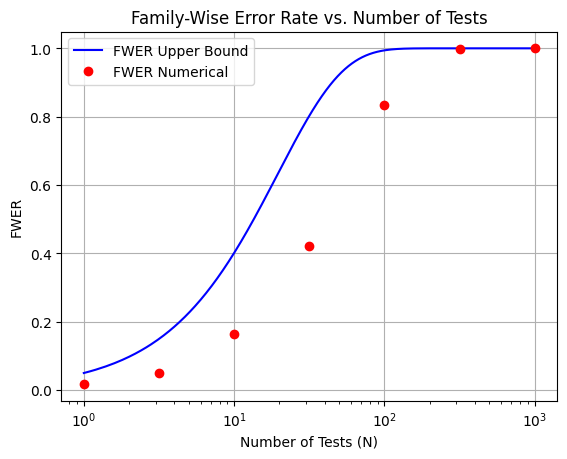

In [40]:
test_counts = np.arange(1, 1000, 0.1)
fwer_bounds = 1 - (1 - alpha)**test_counts

plt.plot(test_counts, fwer_bounds, label='FWER Upper Bound', color='blue')
plt.plot(numer_tests, numer_fwer, 'ro',label='FWER Numerical')
#plt.axhline(FWER_asymp, color='red', linestyle='--', label='Asymptotic FWER')
plt.xlabel('Number of Tests (N)')
plt.ylabel('FWER')
plt.xscale('log')
plt.title('Family-Wise Error Rate vs. Number of Tests')
plt.legend()
plt.grid()
plt.show()